In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Generator

In [2]:
RANDOM_SIZE = 100
IMG_DIM = 28
BATCH_SIZE = 100
EPSILON = 1e-3
LEARNING_RATE = 0.0002

z_dist = keras.Input(shape=(RANDOM_SIZE,),dtype=tf.float32,name='generator_input')
first_layer = keras.layers.Dense(256,activation = tf.nn.relu,name="first_layer_generator")(z_dist)
fake_pred = keras.layers.Dense(784,activation = tf.nn.sigmoid,name="second_layer_generator")(first_layer)
fake_img = keras.layers.Reshape((28,28),name="fake_img")(fake_pred)

generator = keras.Model(z_dist,fake_img)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
first_layer_generator (Dense (None, 256)               25856     
_________________________________________________________________
second_layer_generator (Dens (None, 784)               201488    
_________________________________________________________________
fake_img (Reshape)           (None, 28, 28)            0         
Total params: 227,344
Trainable params: 227,344
Non-trainable params: 0
_________________________________________________________________


# Discriminator

In [3]:
img = keras.Input(shape=(IMG_DIM,IMG_DIM),dtype=tf.float32,name='img_input')
flattened_img = keras.layers.Flatten()(img)
first_layer = keras.layers.Dense(256,activation = tf.nn.relu,name="first_layer_discriminator")(flattened_img)
prediction = keras.layers.Dense(1,activation = tf.nn.sigmoid,name="second_layer_discriminator")(first_layer)

discriminator = keras.Model(img,prediction)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
first_layer_discriminator (D (None, 256)               200960    
_________________________________________________________________
second_layer_discriminator ( (None, 1)                 257       
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________


# Model


In [4]:
class GAN(keras.Model):
  
  def __init__(self,generator,discriminator,**kwargs):
    super(GAN, self).__init__(**kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.generator_loss_tracker = keras.metrics.Mean(name="generator_loss")
    self.discriminator_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

  @property
  def metrics(self):
    return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker
    ]


  def train_step(self,data):
    
    z = np.random.uniform(-1,1,size=(BATCH_SIZE,RANDOM_SIZE))   
    
    with tf.GradientTape() as disc_tape:

      with tf.GradientTape() as gen_tape:
        
        
        
        fake_img = self.generator(z)
        
        fake_predic = self.discriminator(fake_img)

        
        generator_loss = - tf.reduce_mean(tf.math.log(fake_predic+EPSILON))

      real_predic = self.discriminator(data)
      
      discriminator_loss = tf.math.log(real_predic+EPSILON)+tf.math.log(1-fake_predic+EPSILON)
      
      discriminator_loss = - tf.reduce_mean(discriminator_loss)
     
    
    gen_grad = gen_tape.gradient(generator_loss,self.generator.trainable_weights)
    
    disc_grad = disc_tape.gradient(discriminator_loss,self.discriminator.trainable_weights)

   
    self.optimizer.apply_gradients(zip(disc_grad , self.discriminator.trainable_weights))
    self.optimizer.apply_gradients(zip(gen_grad , self.generator.trainable_weights))
    self.generator_loss_tracker.update_state(generator_loss)
    self.discriminator_loss_tracker.update_state(discriminator_loss)

    return {
            "generator_loss": self.generator_loss_tracker.result(),
            "discriminator_loss": self.discriminator_loss_tracker.result()
        }

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

mnist_fashion = np.concatenate([x_train,x_test],axis=0)
mnist_fashion = mnist_fashion.astype('float64')/255

In [6]:
tf.optimizers.Adam(LEARNING_RATE)

In [13]:
model = GAN(generator,discriminator)
model.compile(optimizer=tf.optimizers.Adam(LEARNING_RATE))
model.fit(mnist_fashion,epochs=50, batch_size=BATCH_SIZE)

Epoch 1/50
700/700 [==============================] - 12s 17ms/step - generator_loss: 2.1412 - discriminator_loss: 0.7369
Epoch 2/50
700/700 [==============================] - 12s 16ms/step - generator_loss: 2.1062 - discriminator_loss: 0.6640
Epoch 3/50
700/700 [==============================] - 11s 16ms/step - generator_loss: 1.5995 - discriminator_loss: 0.8852
Epoch 4/50
700/700 [==============================] - 11s 16ms/step - generator_loss: 1.5365 - discriminator_loss: 0.9466
Epoch 5/50
700/700 [==============================] - 11s 16ms/step - generator_loss: 1.4574 - discriminator_loss: 1.0036
Epoch 6/50
700/700 [==============================] - 11s 16ms/step - generator_loss: 1.4499 - discriminator_loss: 0.9946
Epoch 7/50
700/700 [==============================] - 11s 16ms/step - generator_loss: 1.4270 - discriminator_loss: 1.0568
Epoch 8/50
700/700 [==============================] - 11s 16ms/step - generator_loss: 1.4131 - discriminator_loss: 1.0577
Epoch 9/50
700/700 [====

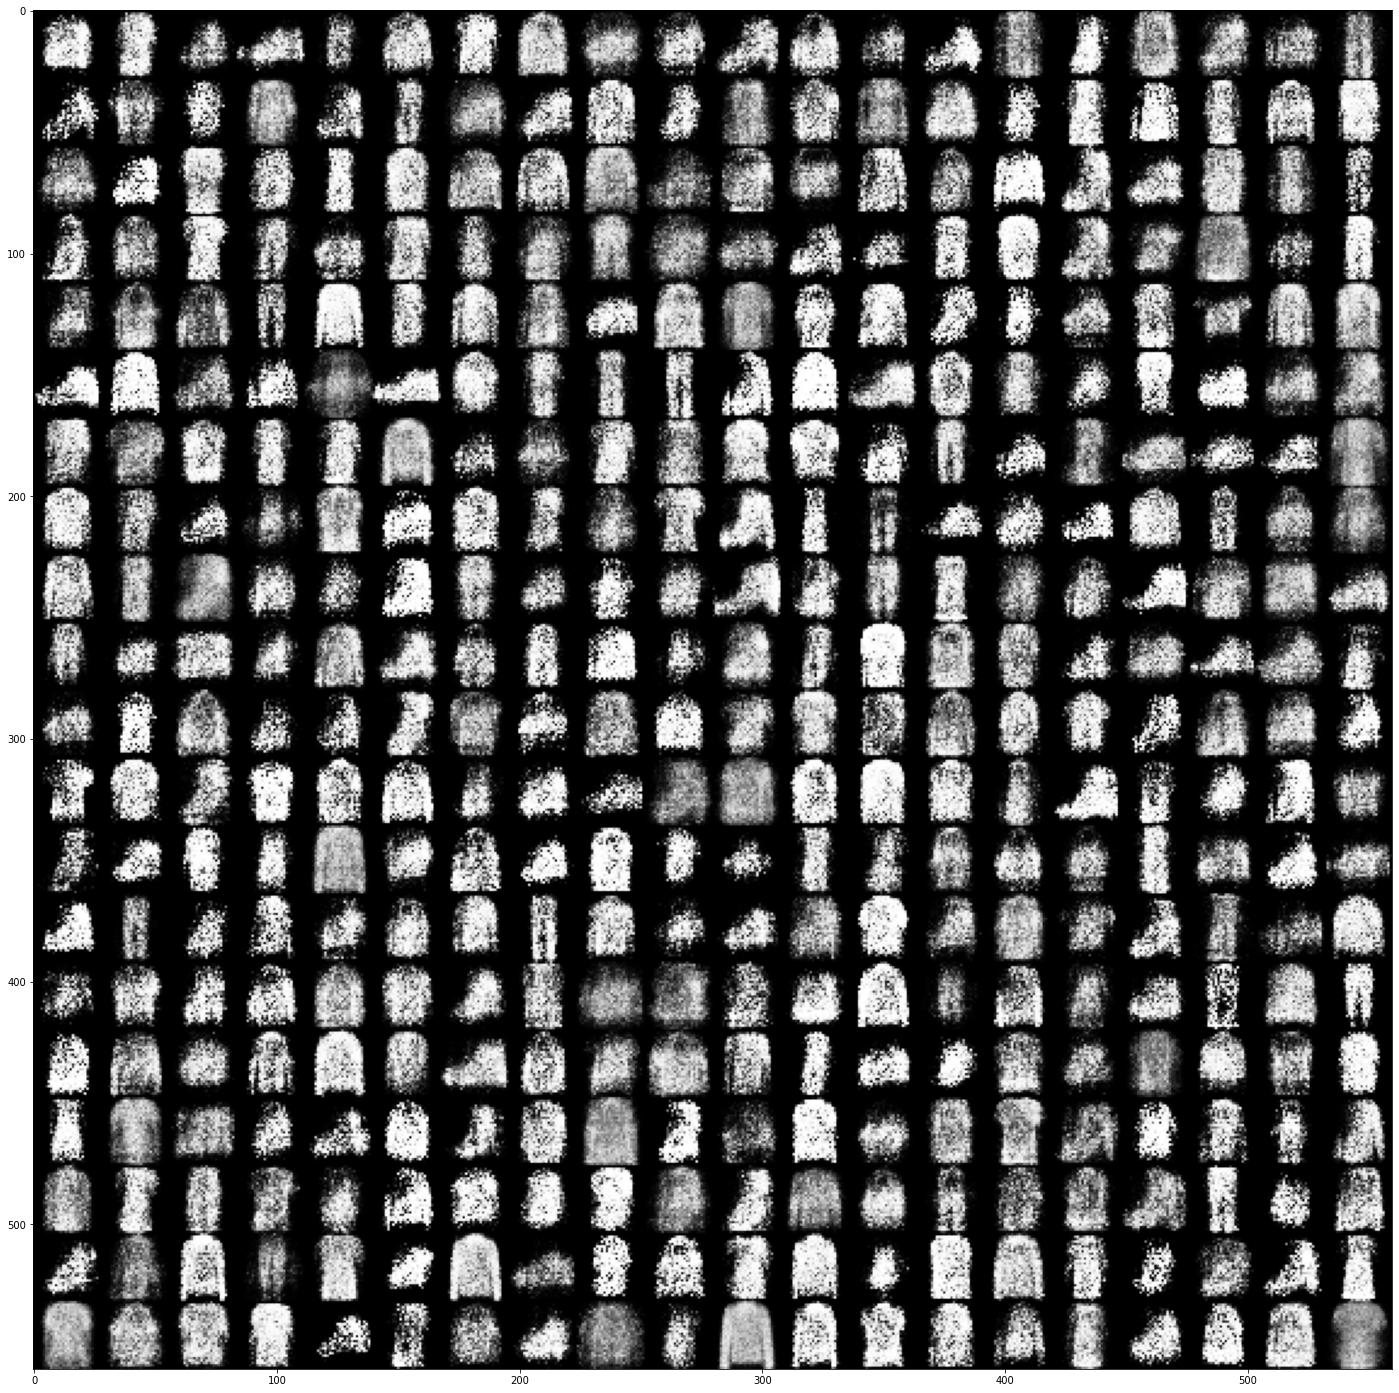

In [14]:
def plot_generated(x=20,y=20):
  import matplotlib.pyplot as plt
  imgs = model.generator(np.random.uniform(-1,1,size=(x*y,RANDOM_SIZE)))
  imgs = imgs.numpy()
  figure = np.zeros(shape=(20*28,20*28),dtype=np.float32)
  for i in range(x):
    for j in range(y):
      figure[i*28:(i+1)*28,j*28:(j+1)*28] = imgs[i*y+j]
  
  plt.figure(figsize=(25,25))
  plt.imshow(figure,cmap="Greys_r")

plot_generated()